# Chainer basic module introduction

Advanced memo is written as "Note". You can skip reading this for the first time reading.

In this tutorial, basic chainer modules are introduced and explained
* Variable
* Link
* Function
* Chain

For other chainer modules are explained in later tutorial.

## Initial setup

Below is typecal `import` statement of chainer modules.

Ref:
 - [http://docs.chainer.org/en/stable/tutorial/basic.html](http://docs.chainer.org/en/stable/tutorial/basic.html)

In [2]:
# Initial setup following 
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

## Check chainer version

In [2]:
print(chainer.__version__)

2.0.0


## Variable
Chainer variable can be created by `Variable` constructor, which creates `chainer.Variable` class object.

When I write `Variable`, it means chainer's class for `Variable`. Please do not confuse with the usual noun of "variable".


Note: the reason why chainer need to use own `Variable`, `Function` class for the calculation instead of just using `numpy` is because back propagation is necessary during deep learning training. 
`Variable` holds its "calculation history" information and `Function` has `backward` method which is differencial function in order to process back propagation. See below for more details

* Chainer Tutorial <a href="http://docs.chainer.org/en/stable/tutorial/basic.html#forward-backward-computation">Forward/Backward Computation</a>

In [3]:
from chainer import Variable
# creating numpy array
# this is `numpy.ndarray` class
a = np.asarray([1., 2., 3.], dtype=np.float32)

# chainer variable is created from `numpy.ndarray` or `cuda.ndarray` (explained later) 
x = Variable(a)

print('a: ', a, ', type: ', type(a))
print('x: ', x, ', type: ', type(x))

a:  [ 1.  2.  3.] , type:  <class 'numpy.ndarray'>
x:  variable([ 1.  2.  3.]) , type:  <class 'chainer.variable.Variable'>


In the above code, numpy data type is explicitly set as `dtype=np.float32`. 
If we don't set data type, `np.float64` may be used as default type in 64-bit environment. However such a precision is usually "too much" and not necessary in machine learning. It is better to use lower precision for computational speed & memory usage.

### attribute
Chainer `Variable` has following attributes

- data
- dtype
- shape
- ndim
- size
- grad


They are very similar to `numpy.ndarray`. You can access following attributes.

In [4]:
# These attributes return the same

print('attributes', 'numpy.ndarray a', 'chcainer.Variable x')
print('dtype', a.dtype, x.dtype)
print('shape', a.shape, x.shape)
print('ndim', a.ndim, x.ndim)
print('size', a.size, x.size)

attributes numpy.ndarray a chcainer.Variable x
dtype float32 float32
shape (3,) (3,)
ndim 1 1
size 3 3


In [5]:
# Variable class has debug_print function, to show this Variable's properties.
x.debug_print()

"<variable at 0x2058c475748>\n- device: CPU\n- backend: <class 'numpy.ndarray'>\n- shape: (3,)\n- dtype: float32\n- statistics: mean=2.00000000, std=0.81649661\n- grad: None"

One exception is `data` attribute, chainer `Variable`'s data refers `numpy.ndarray`

In [6]:
# x = Variable(a)

# `a` can be accessed via `data` attribute from chainer `Variable`
print('x.data is a : ', x.data is a)  # True -> means the reference of x.data and a are same. 
print('x.data: ', x.data)

x.data is a :  True
x.data:  [ 1.  2.  3.]


## Function

We want to process some calculation to `Variable`.
`Variable` can be calculated using

- arithmetric operation (Ex. `+`, `-`, `*`, `/`)
- method which is subclass of `chainer.Function` (Ex. `F.sigmoid`, `F.relu`)

In [7]:
# Arithmetric operation example
x = Variable(np.array([1, 2, 3], dtype=np.float32))
y = Variable(np.array([5, 6, 7], dtype=np.float32))

# usual arithmetric operator (this case `*`) can be used for calculation of `Variable`
z = x * y
print('z: ', z.data, ', type: ', type(z))

z:  [  5.  12.  21.] , type:  <class 'chainer.variable.Variable'>


Only basic calculation can be done with arithmetric operations. 

Chainer provides a set of widely used functions via `chainer.functions`, for example sigmoid function or ReLU (Rectified Linear Unit) function which is popularly used as activation function in deep learning.

In [8]:
# Functoin operation example
import chainer.functions as F

x = Variable(np.array([-1.5, -0.5, 0, 1, 2], dtype=np.float32))
sigmoid_x = F.sigmoid(x)  # sigmoid function. F.sigmoid is subclass of `Function`
relu_x = F.relu(x)        # ReLU function. F.relu is subclass of `Function`

print('x: ', x.data, ', type: ', type(x))
print('sigmoid_x: ', sigmoid_x.data, ', type: ', type(sigmoid_x))
print('relu_x: ', relu_x.data, ', type: ', type(relu_x))

x:  [-1.5 -0.5  0.   1.   2. ] , type:  <class 'chainer.variable.Variable'>
sigmoid_x:  [ 0.18242553  0.37754068  0.5         0.7310586   0.88079709] , type:  <class 'chainer.variable.Variable'>
relu_x:  [ 0.  0.  0.  1.  2.] , type:  <class 'chainer.variable.Variable'>


Note: You can find capital letter of `Function` like `F.Sigmoid` or `F.ReLU`. 
Basically, these capital letter is actual class implmentation of `Function` while small letter method is *getter* method of these capital lettered instance.

It is recommended to use **small letter** method when you use `F.xxx`.

Just a side note, sigmoid and ReLU function are non-linear function whose form is like this.

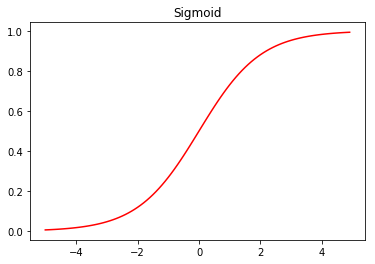

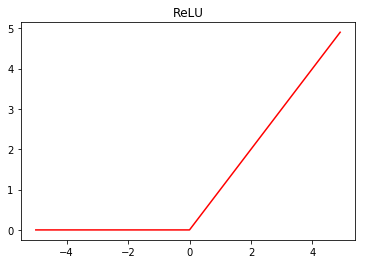

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_chainer_function(f, xmin=-5, xmax=5, title=None):
    """draw graph of chainer `Function` `f`

    :param f: function to be plotted
    :type f: chainer.Function
    :param xmin: int or float, minimum value of x axis
    :param xmax: int or float, maximum value of x axis
    :return:
    """
    a = np.arange(xmin, xmax, step=0.1)
    x = Variable(a)
    y = f(x)
    plt.clf()
    plt.figure()
    # x and y are `Variable`, their value can be accessed via `data` attribute
    plt.plot(x.data, y.data, 'r')
    if title is not None:
        plt.title(title)
    plt.show()

plot_chainer_function(F.sigmoid, title='Sigmoid')
plot_chainer_function(F.relu, title='ReLU')

## Link

`Link` is similar to `Function`, but **it owns internal parameter**. This internal parameter is tuned during training of machine learning. 

`Link` is similar notion of `Layer` in caffe. Chainer provides layers which is introduced in popular papers via `chainer.links`. For example, Linear layer, Convolutional layer. 

Let's see the example,
(below explanation is almost same with [official tutorial](http://docs.chainer.org/en/stable/tutorial/basic.html#links))

In [10]:
import chainer.links as L

in_size = 3  # input vector's dimension
out_size = 2  # output vector's dimension

linear_layer = L.Linear(in_size, out_size)  # L.linear is subclass of `Link`

"""linear_layer has 2 internal parameters `W` and `b`, which are `Variable`"""
print('W: ', linear_layer.W.data, ', shape: ', linear_layer.W.shape)
print('b: ', linear_layer.b.data, ', shape: ', linear_layer.b.shape)

W:  [[-0.09607964  0.4963097   0.0818873 ]
 [-0.7667641  -0.20673235 -0.59234428]] , shape:  (2, 3)
b:  [ 0.  0.] , shape:  (2,)


Note that internal parameter `W` is initialized with a random value. So every time you execute above code, the result will be different (try and check it!).

This Linear layer will take 3-dimensional vectors [x0, x1, x2...] (`Variable` class) as input and outputs 2-dimensional vectors [y0, y1, y2...] (`Variable` class).

In equation form, 
$$ y_i = W * x_i + b $$
where `i = 0, 1, 2...` denotes each "minibatch" of input/output. 

[Note] See source code of `Linear` class, you can easily understand it is just calling `F.linear` by 
<pre>
    return linear.linear(x, self.W, self.b)
</pre>

In [11]:
x0 = np.array([1, 0, 0], dtype=np.float32)
x1 = np.array([1, 1, 1], dtype=np.float32)

x = Variable(np.array([x0, x1], dtype=np.float32))
y = linear_layer(x)
print('W: ', linear_layer.W.data)
print('b: ', linear_layer.b.data)
print('x: ', x.data)  # input is x0 & x1
print('y: ', y.data)  # output is y0 & y1

W:  [[-0.09607964  0.4963097   0.0818873 ]
 [-0.7667641  -0.20673235 -0.59234428]]
b:  [ 0.  0.]
x:  [[ 1.  0.  0.]
 [ 1.  1.  1.]]
y:  [[-0.09607964 -0.7667641 ]
 [ 0.48211735 -1.56584084]]


Let me emphasize the difference between `Link` and `Function`. `Function``s input-output relationship is fixed. On the other hand, `Link` module has internal parameter and the function behavior can be changed by modifying (tuning) this internal parameter.

In [12]:
# Force update (set) internal parameters
linear_layer.W.data = np.array([[1, 2, 3], [0, 0, 0]], dtype=np.float32)
linear_layer.b.data = np.array([3, 5], dtype=np.float32)

# below is same code with above cell, but output data y will be different
x0 = np.array([1, 0, 0], dtype=np.float32)
x1 = np.array([1, 1, 1], dtype=np.float32)

x = Variable(np.array([x0, x1], dtype=np.float32))
y = linear_layer(x)
print('W: ', linear_layer.W.data)
print('b: ', linear_layer.b.data)
print('x: ', x.data)  # input is x0 & x1
print('y: ', y.data)  # output is y0 & y1

W:  [[ 1.  2.  3.]
 [ 0.  0.  0.]]
b:  [ 3.  5.]
x:  [[ 1.  0.  0.]
 [ 1.  1.  1.]]
y:  [[ 4.  5.]
 [ 9.  5.]]


The value of output `y` is different compared to above code, even though we input same value of `x`.

These internal parameters are "tuned" during training in machine learning. Usually, we do not need to set these internal parameter `W` or `b` manually, chainer will automatically update these internal parameters during training through back propagation.

## Chain

`Chain` is to construct neural networks. It usually consists of several combination of `Link` and `Function` modules.

Let's see example,

In [15]:
from chainer import Chain, Variable


# Defining your own neural networks using `Chain` class
class MyChain(Chain):
    def __init__(self):
        super(MyChain, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(2, 2)
            self.l2 = L.Linear(2, 1)
        
    def __call__(self, x):
        h = self.l1(x)
        return self.l2(h)
    

x = Variable(np.array([[1, 2], [3, 4]], dtype=np.float32))

model = MyChain()
y = model(x)

print('x: ', x.data)  # input is x0 & x1
print('y: ', y.data)  # output is y0 & y1

x:  [[ 1.  2.]
 [ 3.  4.]]
y:  [[-2.61815786]
 [-5.45522881]]


x:  [[ 1.  2.]
 [ 3.  4.]]
y:  [[ 0.62971944]
 [ 0.63566327]]


Based on the [official doc](http://docs.chainer.org/en/stable/tutorial/basic.html#write-a-model-as-a-chain), `Chain` class provides following functionality
* parameter management
* CPU/GPU migration support
* save/load features

to provide convinient reusability of your neural network code.

Memo: 
Above `init_scope()` method is introduced in chainer v2,
and `Link` class instances are initialized inside this scope.
 
In chainer v1, `Chain` was initialized as follows.
Concretely, `Link` class instances are initialized in the argument of super method.
For backward compatibility, you may use this type of initialization in chainer v2 as well.

In [16]:
from chainer import Chain, Variable


# Defining your own neural networks using `Chain` class
class MyChain(Chain):
    def __init__(self):
        super(MyChain, self).__init__(
            l1=L.Linear(2, 2),
            l2=L.Linear(2, 1)
        )
        
    def __call__(self, x):
        h = self.l1(x)
        return self.l2(h)
    

x = Variable(np.array([[1, 2], [3, 4]], dtype=np.float32))

model = MyChain()
y = model(x)

print('x: ', x.data)  # input is x0 & x1
print('y: ', y.data)  # output is y0 & y1

x:  [[ 1.  2.]
 [ 3.  4.]]
y:  [[-0.10704891]
 [-0.61191183]]
